Latest available date in dataset: 2024-12-31


Enter the commodity:  edible oil
Enter the state:  uttar pradesh
Enter the district:  varanasi


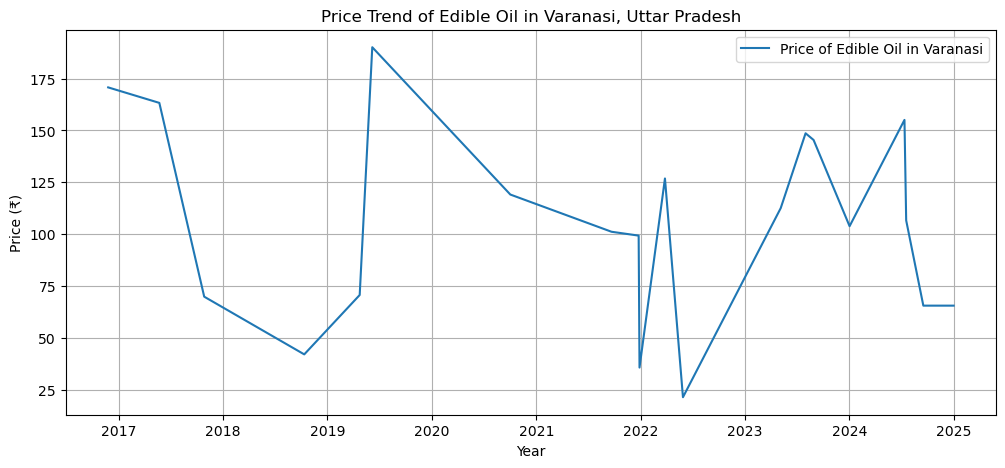

Random Forest Prediction - MAE: 2.46, RMSE: 5.44, Accuracy: 97.08%
ARIMA Model - MAE: 9.79, RMSE: 22.92, Accuracy: 88.20%
You can enter a future date between 2025-01-31 and 2025-12-31 for prediction.


Enter a future date (YYYY-MM-DD) for price prediction:  2025-08-28


Forecasted price for 2025-08-31 is ₹60.51


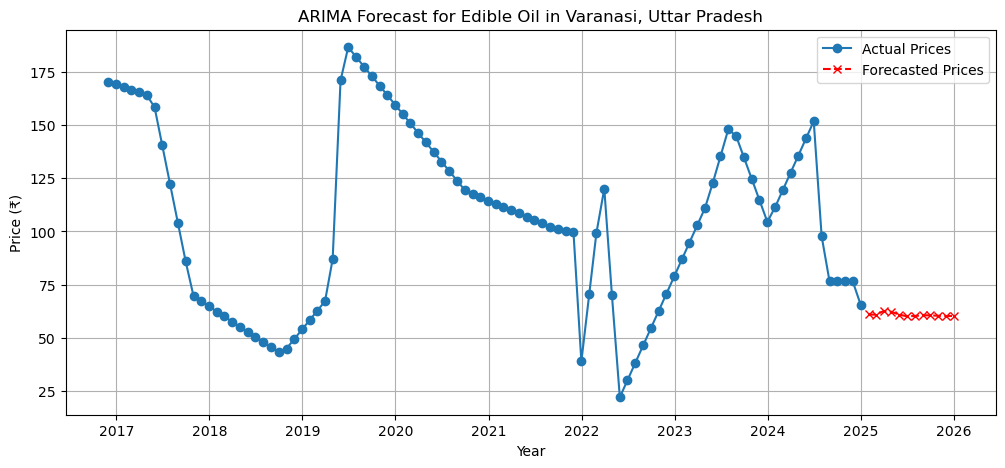

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------------- Step 1: Load Dataset ----------------
file_path = "commodity_prices_updated1.csv"

try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print("Error: The dataset file was not found. Please check the file path.")
    exit()

# Convert Date column to datetime format
if "Date" not in df.columns:
    print("Error: 'Date' column not found in dataset.")
    exit()

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)  # Remove invalid dates
df = df.sort_values(by='Date')

# Feature Engineering: Extract Year, Month
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Latest available date in dataset
max_available_date = df['Date'].max()
print(f"Latest available date in dataset: {max_available_date.date()}")

# ---------------- Step 2: User Input Handling ----------------
commodity = input("Enter the commodity: ").strip().title()
state = input("Enter the state: ").strip().title()
district = input("Enter the district: ").strip().title()

df_filtered = df[
    (df["Commodity"].str.title() == commodity) &
    (df["State"].str.title() == state) &
    (df["District"].str.title() == district)
].copy()

if df_filtered.empty:
    print("Error: No data found for the given commodity, state, and district. Please check your inputs.")
    exit()

# Convert categorical column 'Season' to numerical codes
if "Season" in df_filtered.columns:
    df_filtered['Season_Code'] = df_filtered['Season'].astype('category').cat.codes
else:
    print("Error: 'Season' column missing from dataset.")
    exit()

# ---------------- Step 3: Data Visualization ----------------
plt.figure(figsize=(12, 5))
plt.plot(df_filtered["Date"], df_filtered["Price"], label=f"Price of {commodity} in {district}")
plt.xlabel("Year")
plt.ylabel("Price (₹)")
plt.title(f"Price Trend of {commodity} in {district}, {state}")
plt.legend()
plt.grid()
plt.show()

# ---------------- Step 4: Machine Learning Model ----------------
X = df_filtered[['Year', 'Month', 'Season_Code']]
y = df_filtered['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Accuracy calculation

print(f"Random Forest Prediction - MAE: {mae:.2f}, RMSE: {rmse:.2f}, Accuracy: {100 - mape:.2f}%")

# ---------------- Step 5: ARIMA Forecasting ----------------
if len(df_filtered) < 30:
    print("Not enough data for ARIMA modeling. Skipping forecast.")
else:
    df_filtered.set_index('Date', inplace=True)
    df_filtered = df_filtered[['Price']].asfreq('ME').ffill()  # Monthly-end frequency

    # Fit ARIMA model
    try:
        arima_model = ARIMA(df_filtered, order=(5, 1, 0))
        arima_fit = arima_model.fit()
    except Exception as e:
        print(f"ARIMA model training failed: {e}")
        exit()

    # Forecast next 12 months
    forecast_steps = 12
    forecast_dates = pd.date_range(df_filtered.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='ME')
    forecast_values = arima_fit.forecast(steps=forecast_steps)

    forecast_df = pd.DataFrame({"Forecasted Price": forecast_values}, index=forecast_dates)

    # ARIMA Model Evaluation
    y_arima_pred = arima_fit.predict(start=0, end=len(df_filtered) - 1)
    y_actual = df_filtered["Price"]

    arima_mae = mean_absolute_error(y_actual, y_arima_pred)
    arima_rmse = np.sqrt(mean_squared_error(y_actual, y_arima_pred))
    arima_mape = np.mean(np.abs((y_actual - y_arima_pred) / y_actual)) * 100

    print(f"ARIMA Model - MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}, Accuracy: {100 - arima_mape:.2f}%")

    # Display forecast date range
    print(f"You can enter a future date between {forecast_dates[0].date()} and {forecast_dates[-1].date()} for prediction.")

    # ---------------- Step 6: Forecast for a Specific Date ----------------
    def get_forecast_price(date_str):
        try:
            date = pd.to_datetime(date_str)
            nearest_date = forecast_df.index[forecast_df.index.get_indexer([date], method="nearest")[0]]
            return f"Forecasted price for {nearest_date.date()} is ₹{forecast_df.loc[nearest_date, 'Forecasted Price']:.2f}"
        except (KeyError, ValueError):
            return "Invalid date. Please enter a valid date in YYYY-MM-DD format within the forecast range."

    user_input_date = input("Enter a future date (YYYY-MM-DD) for price prediction: ")
    print(get_forecast_price(user_input_date))

    # ---------------- Step 7: Plot Forecasted Prices ----------------
    plt.figure(figsize=(12, 5))
    plt.plot(df_filtered.index, df_filtered['Price'], label="Actual Prices", marker='o')
    plt.plot(forecast_df.index, forecast_df["Forecasted Price"], label="Forecasted Prices", linestyle="dashed", color="red", marker='x')
    plt.xlabel("Year")
    plt.ylabel("Price (₹)")
    plt.title(f"ARIMA Forecast for {commodity} in {district}, {state}")
    plt.legend()
    plt.grid()
    plt.show()

